In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # For y values
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

In [2]:
np.random.seed(123)  # for reproducibility

## Some Helping Functions

In [3]:
def print_heatmap(data):
    heatmap = sns.heatmap(data)
    heatmap.set(xlabel='Pseudorapidity', ylabel='Azimuthal Angle')
    print(heatmap)
    #plt.imshow(data, cmap='jet', interpolation='nearest')
    #plt.show()

In [4]:
def get_predicted_values(output_values):
    predicted_values = []
    for probability in output_values:
        if probability[0] > probability[1]:
            predicted_values.append(0)
        else:
            predicted_values.append(1)
    return predicted_values

# Reading the data

First we read the Signal Data and produce a heatmap from the average of all lines. We do so, in order to get the feeling of what our data looks like.

In [5]:
signal_data = pd.read_csv('signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', sep="	", header=None, dtype=np.float32)
signal_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,616,617,618,619,620,621,622,623,624,625
count,11298.0,11298.0,11298.0,11298.0,11298.0,1.129800e+04,11298.0,1.129800e+04,11298.0,11298.000000,...,11298.0,11298.0,11298.0,11298.0,11298.0,11298.0,11298.0,11298.0,11298.0,0.0
mean,0.0,0.0,0.0,0.0,0.0,2.397279e-08,0.0,6.124086e-08,0.0,0.000004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
std,0.0,0.0,0.0,0.0,0.0,2.548117e-06,0.0,6.509417e-06,0.0,0.000354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
min,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
25%,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
50%,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
75%,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
max,0.0,0.0,0.0,0.0,0.0,2.708446e-04,0.0,6.918993e-04,0.0,0.037184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [6]:
print(signal_data.shape)
print(signal_data.iloc[1:10,625])

(11298, 626)
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: 625, dtype: float32


As seen, the data read has a last column (no. 626) without data. This happens because the data read has trailing spaces. We need to remove such data.

In [7]:
signal_data.drop(625, axis=1, inplace=True)
print(signal_data.shape)

(11298, 625)


Then, we calculate the average of all observations.

In [8]:
mean_signal = signal_data.mean()
print(mean_signal.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    0.000000e+00
4    0.000000e+00
5    2.397279e-08
6    0.000000e+00
7    6.124086e-08
8    0.000000e+00
9    3.770772e-06
dtype: float32


Now draw the Heatmap

(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


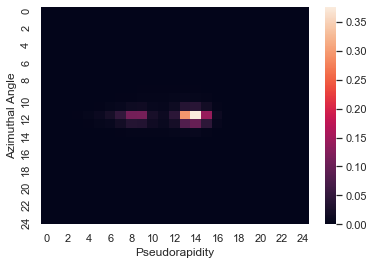

In [9]:
mean_signal_matrix = mean_signal.values
print(mean_signal_matrix.shape)
mean_signal_matrix = mean_signal_matrix.reshape((25,25))

print_heatmap(mean_signal_matrix)

We then add a last column, with the value of `1`. This last column classify this data as signal data. After creating the full dataset we will rename this column to _class_.

In [10]:
signal_data[625] = 1

In [11]:
signal_data.iloc[0:10,625]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: 625, dtype: int64

After preprocessing the _signal_ data, we will perform the same steps with the _background_ data.

In [12]:
background_data = pd.read_csv('background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt', sep="	", header=None, dtype=np.float32)
print(background_data.shape)

(11298, 626)


In [13]:
background_data.drop(625, axis=1, inplace=True)
print(background_data.shape)

(11298, 625)


In [14]:
mean_background = background_data.mean()
print(mean_background.iloc[1:10,])

1    0.000000e+00
2    0.000000e+00
3    8.339239e-08
4    0.000000e+00
5    1.226879e-06
6    9.698673e-07
7    3.696426e-06
8    8.896710e-06
9    5.325904e-06
dtype: float32


(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


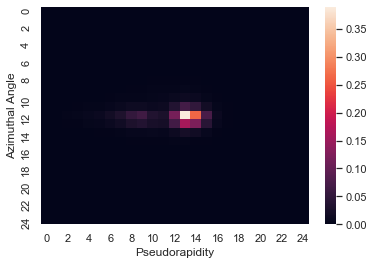

In [15]:
mean_background_matrix = mean_background.values
print(mean_background_matrix.shape)
mean_background_matrix = mean_background_matrix.reshape((25,25))

print_heatmap(mean_background_matrix)

We modify this data, to point out that this is the background data, by setting the last column to `0`.

In [16]:
background_data[625] = 0

In [17]:
background_data.iloc[0:10,625]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 625, dtype: int64

Now we concatenate the data and shuffle it in order to randomize its columns.

In [18]:
frames = [signal_data, background_data]
full_data = pd.concat(frames)

In [19]:
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.rename(columns={625:'class'}, inplace=True)

Now let's examine how our data looks like.

In [20]:
from IPython.core.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 15, 
                       'display.float_format', '{:.2f}'.format):
    display(full_data)

,0,1,2,3,4,5,6,...,619,620,621,622,623,624,class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22591,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22592,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22593,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
22594,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0


# Defining and Training the model

Split the full dataset into _test_ and _train_ data in a 70-30% rate.

In [25]:
train_data, test_data = train_test_split(full_data, test_size = 0.15)
print(train_data.shape)
print(test_data.shape)

(19206, 626)
(3390, 626)


The _Keras_ framework, in order to train its network must receive the dependent and independent variables in  separated tables.

In [26]:
X_train = train_data.iloc[:, :-1]
print(X_train.shape)
Y_train = train_data.iloc[:,-1:]
print(Y_train.shape)

(19206, 625)
(19206, 1)


In [27]:
X_test = test_data.iloc[:, :-1]
print(X_test.shape)
Y_test = test_data.iloc[:,-1:]
print(Y_test.shape)

(3390, 625)
(3390, 1)


We must convert the dependent variable to be a probability distribution of the possible outcomes, thus, a value of output `1` must become the probabilities `(0, 1)`. Conversely, a `0` outcome value must become the pair `(1, 0)`.

In [28]:
Y_train = to_categorical(Y_train.values, num_classes=2)
Y_train.shape()

TypeError: 'tuple' object is not callable

## Neural Network Architecture Definition

We defined a simple NN, with only two hidden layer.

After defining the NN architecture we train it using the `fit` method. We trained it for 50 epochs (backpropagation cycles). 

In [188]:
train_data, test_data = train_test_split(full_data, test_size = 0.3)

X_train = train_data.iloc[:, :-1]
Y_train = train_data.iloc[:,-1:]

X_test = test_data.iloc[:, :-1]
Y_test = test_data.iloc[:,-1:]

Y_train = to_categorical(Y_train.values, num_classes=2)
Y_test = to_categorical(Y_test.values, num_classes=2)

In [193]:
dimof_input = X_train.shape[1]

model = Sequential()

model.add(Dense(units=512, activation='relu', input_dim=dimof_input))
model.add(Dropout(0.1))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [194]:
model.fit(X_train.values, Y_train, batch_size=500, epochs=500, verbose=0)

score = model.evaluate(X_test.values, Y_test, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[2.1418965712007227, 0.7344741]


After training the model we need to evaluate it.

Now let's take a look at the missclassified observations.

In [191]:
Y_test_predicted = model.predict(X_test, verbose=0)
Y_test_predicted

array([[2.0593097e-06, 9.9999797e-01],
       [8.9719910e-03, 9.9102801e-01],
       [1.0000000e+00, 1.1530095e-31],
       ...,
       [1.0000000e+00, 5.7938883e-11],
       [5.3272688e-01, 4.6727318e-01],
       [2.1876331e-04, 9.9978119e-01]], dtype=float32)

Now we calculate the false negatives and also the false positives by comparing the true value with the predicted one.

In [192]:
Y_test_predicted_values = get_predicted_values(Y_test_predicted)
Y_test_values = get_predicted_values(Y_test)
print(Y_test_predicted_values[1:10])
print(Y_test_values[1:10])

false_positives = []
false_negatives = []
for i in range(len(Y_test_values)):
    if Y_test_values[i] == 0 and Y_test_predicted_values[i] == 1:
        false_positives.append(i)
    elif Y_test_values[i] == 1 and Y_test_predicted_values[i] == 0:
        false_negatives.append(i)
        
print("False Positive Rate: {:.2f}".format(len(false_positives)/len(Y_test_values)))
print("False Negative Rate: {:.2f}".format(len(false_negatives)/len(Y_test_values)))

[1, 0, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 0, 0, 1, 0, 0, 1]
False Positive Rate: 0.14
False Negative Rate: 0.13


And try to visualize the heatmaps for false positives and negatives. Firstly the false negatives, where the network was supposed to answer _Signal_, but instead, it answered _Background_.

[46, 53, 59, 62, 66, 107, 116, 131, 132]
(906, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


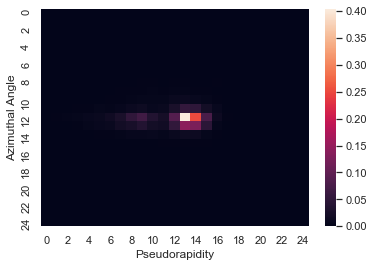

In [34]:
print(false_negatives[1:10])
false_negatives_values = X_test.iloc[false_negatives,]
print(false_negatives_values.shape)

mean_false_negatives = false_negatives_values.mean().values
print(mean_false_negatives.shape)
mean_false_negatives = mean_false_negatives.reshape((25,25))

print_heatmap(mean_false_negatives)

Then we examine the cases in which the network should have responded _Background_, but it answered _Signal_.

[6, 21, 32, 38, 39, 45, 47, 64, 65]
(857, 625)
(625,)
AxesSubplot(0.125,0.125;0.62x0.755)


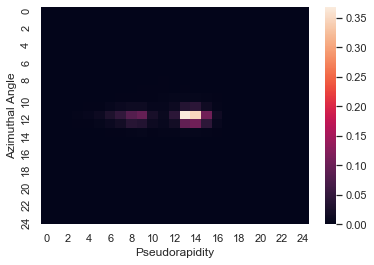

In [105]:
print(false_positives[1:10])
false_positives_values = X_test.iloc[false_positives,]
print(false_positives_values.shape)

mean_false_positives = false_positives_values.mean().values
print(mean_false_positives.shape)
mean_false_positives = mean_false_positives.reshape((25,25))

print_heatmap(mean_false_positives)

## Apresentação da solução para classificao de Jets 

 

### Divisão em grupos. Criem ao menos 4 grupos 
### Apresentacao  sera  no  dia  21/02  (sexta) 

 

`Objetivo:` 

1. Modificar a rede neural apresentada para melhorar a acurácia do modelo ;

1. Comparar o modelo de rede neural com outro modelo do scikit learn de sua preferência;

1. Utilize os recursos aprendidos em aula: regularização, validação cruzada,  
busca por hyperparâmetros, preparação de dados, etc para validar os resultados e buscar o melhor modelo;

1. Gere curvas de aprendizado do modelo para explicar o impacto das mudanças feitas no modelo . 


`Entregar:` 
 

1. Descrição completa e documentada da exploração em jupyter;

1. Apresentacao dos resultados usando slides (15 m);

1. Apresentar uma análise exploratória do problema;

1. Explique as acoes tomadas para definir o modelo;

1. Apresente a comparação entre os modelos;

1. Caracterize a acurácia em termos de falso positivo e falso negativo.

In [143]:
history = model.fit(X_train.values, Y_train, batch_size=500, epochs=700, verbose=0)

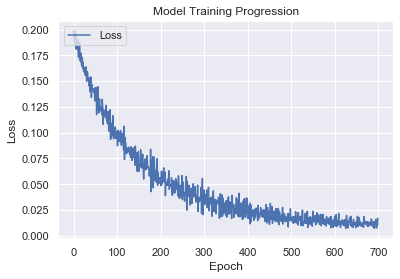

In [144]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.title('Model Training Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

In [185]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
Y_o = enc.fit_transform(Y_pred.reshape(-1,1)).toarray()
enc = OneHotEncoder(handle_unknown='ignore')

print(Y_o.shape)
print(Y_test.shape)

print(classification_report(Y_test, Y_o))

(6779, 2)
(6779, 2)
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      3311
           1       0.74      0.73      0.73      3468

   micro avg       0.73      0.73      0.73      6779
   macro avg       0.73      0.73      0.73      6779
weighted avg       0.73      0.73      0.73      6779
 samples avg       0.73      0.73      0.73      6779

